In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import os, time
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
import numpy as np
import matplotlib.pyplot as plt



In [96]:
df = pd.read_excel("housing_data.xlsx",)
df.head()

X = df[["LSTAT"]].values
y = df["MEDV"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

sc = StandardScaler()

X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)


In [97]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(1,)),
    tf.keras.layers.Dense(units=16, activation='sigmoid', name='hidden1'),
    tf.keras.layers.Dense(units=16, activation='sigmoid', name='hidden2'),
    tf.keras.layers.Dense(units=1, name='output')
    ])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mse',
    metrics=['mse'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 16)                32        
_________________________________________________________________
hidden2 (Dense)              (None, 16)                272       
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [98]:
tf_fit = model.fit(x=X_train_std, y=y_train,
        batch_size=16,
        validation_split=0.1,
        epochs=200, 
        verbose=1)

Epoch 1/200
20/20 [==============================] - 0s 7ms/step - loss: 536.0616 - mse: 536.0616 - val_loss: 424.6918 - val_mse: 424.6918
Epoch 2/200
20/20 [==============================] - 0s 18ms/step - loss: 394.7525 - mse: 394.7525 - val_loss: 312.0547 - val_mse: 312.0547
Epoch 3/200
20/20 [==============================] - 0s 2ms/step - loss: 303.6605 - mse: 303.6605 - val_loss: 237.9757 - val_mse: 237.9757
Epoch 4/200
20/20 [==============================] - 0s 2ms/step - loss: 236.3485 - mse: 236.3485 - val_loss: 175.6322 - val_mse: 175.6322
Epoch 5/200
20/20 [==============================] - 0s 2ms/step - loss: 181.0138 - mse: 181.0138 - val_loss: 130.3246 - val_mse: 130.3246
Epoch 6/200
20/20 [==============================] - 0s 2ms/step - loss: 144.2499 - mse: 144.2499 - val_loss: 101.0366 - val_mse: 101.0366
Epoch 7/200
20/20 [==============================] - 0s 2ms/step - loss: 120.7678 - mse: 120.7678 - val_loss: 82.6405 - val_mse: 82.6405
Epoch 8/200
20/20 [=========

In [99]:
y_train_pred = model(X_test_std)
y_test_pred = model(X_test_std)

In [100]:
def reg_plot(ax, X, y, y_pred, title, color="steelblue"):
    ax.scatter(X, y, c=color, edgecolor="white", s=70)
    ax.plot(X, y_pred, color="black", lw=2)
    ax.set_title(title)
    return

def res_plot(ax, y_pred, y, title, color="steelblue"):
    ax.scatter(y_pred, y_pred - y, c=color, marker="o", edgecolor="white", s=70)
    ax.hlines(y=0, xmin=-10, xmax=50, color="black", lw=2)
    ax.axes.set_aspect("equal")
    ax.set_title(title)

def store_results(df, model_name, y_train, y_test, y_train_pred, y_test_pred):

    MSE_train = mean_squared_error(y_train, y_train_pred)
    MSE_test = mean_squared_error(y_test, y_test_pred)

    R2_train = r2_score(y_train, y_train_pred)
    R2_test = r2_score(y_test, y_test_pred)

    data = {
        "Model": model_name,
        "MSE Train": [MSE_train],
        "MSE Test": [MSE_test],
        "R2 Train": [R2_train],
        "R2 Test": [R2_test],
    }
    dft = pd.DataFrame(data=data)
    return df.append(dft, ignore_index=True)

In [101]:

def run_model_ANN(model, model_name, X_train, X_train_std, y_train, X_test, X_test_std, y_test, df):

    y_train_pred = model(X_train_std).numpy().ravel()
    y_test_pred = model(X_test_std).numpy().ravel()

    # Indices for sorting during plotting
    idx_train = np.argsort(X_train_std, axis=0).ravel()
    idx_test = np.argsort(X_test_std, axis=0).ravel()

    fig, ax = plt.subplots(
        1, 2, figsize=(10, 5), constrained_layout=True, sharex=True, sharey=True
    )
    reg_plot(ax=ax[0], X=X_train[idx_train,:1], y=y_train[idx_train], y_pred=y_train_pred[idx_train], title="Train")
    reg_plot(
        ax=ax[1],
        X=X_test[idx_test,:1],
        y=y_test[idx_test],
        y_pred=y_test_pred[idx_test],
        title="test",
        color="limegreen",
    )
    fig.supxlabel("Lower status of the population [LSTAT]")
    fig.supylabel("Average number of rooms [RM]")

    fig, ax = plt.subplots(
        1, 2, figsize=(9, 5), constrained_layout=True, sharex=True, sharey=True
    )
    res_plot(ax=ax[0], y_pred=y_train_pred, y=y_train, title="Train")
    res_plot(ax=ax[1], y_pred=y_test_pred, y=y_test, title="Test", color="limegreen")
    fig.supxlabel("Predicted values")
    fig.supylabel("Residual")

    df = store_results(
        df=df,
        model_name=model_name,
        y_train=y_train,
        y_train_pred=y_train_pred,
        y_test=y_test,
        y_test_pred=y_test_pred,
    )

    return df

C:\Users\nnnpo\AppData\Local\Temp\ipykernel_8036\820358675.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(dft, ignore_index=True)


,Model,MSE Train,MSE Test,R2 Train,R2 Test
0,ANN,25.340797,28.95488,0.701045,0.652258


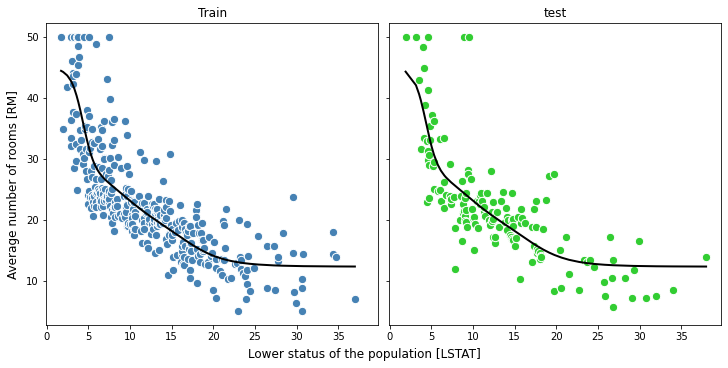

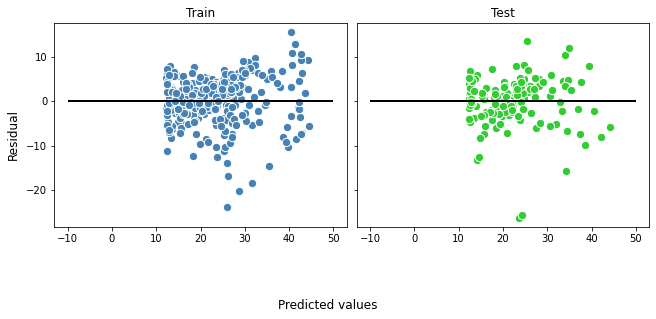

In [102]:
dfAll = pd.DataFrame()
dfAll = run_model_ANN(
    model=model,
    model_name=f"ANN",
    X_train=X_train,
    X_train_std=X_train_std,
    y_train=y_train,
    X_test=X_test,
    X_test_std=X_test_std,
    y_test=y_test,    
    df=dfAll,
    )

display(dfAll)